**Pneumonia type classification using Loss Calibration for BNN approach**

We are going to focus on three classes of images:

1. Normal: not pneumonia
2. Bacterial Pneumonia
3. Viral Pneumonia: not covid-19
4. Covid-19

We want to maximize the capacity of the model to predict correctly the covid-19 cases from images and avoid false negatives mostly for this class. Then we are going to proposse a utility function based on the paper idea in order to obtain good results for this task.

In [108]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Layer, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam
from keras.utils import to_categorical
import random


import sys
sys.path.insert(0, './code/')
sys.path.insert(0, './data/')
import lcbnn_multiclass as lcbnn
from utils import plot_confusion_matrix
import tensorflow as tf
import numpy as np
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.cm as cm



np.random.seed(seed=0)
random.seed(0)

In [2]:
#paths
data = './data/'
covid_path = data + './data/COVID-19/' 
x_ray_path = data + './data/chest_xray/'

In [146]:
IMG_SIZE = 32

In [147]:
def read_images(images_paths):
    images = []
    for image_path in images_paths:
        image = cv2.imread(image_path)
        # resize image
        image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
        # transform to grayscale
        # image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        images.append(image)
    # reshape images to 1D array
    # images = np.array(images).reshape(-1,IMG_SIZE*IMG_SIZE)
    return np.array(images)

In [148]:
X_train = np.array([])
y_train = np.array([])
X_test = np.array([])
y_test = np.array([])
X_val = np.array([])
y_val = np.array([])

In [149]:
# read covid images
covid_images_paths = [covid_path + file_name for file_name in os.listdir(covid_path)]
covid_images = read_images(covid_images_paths)

In [150]:
covid_images.shape

(196, 32, 32, 3)

In [151]:
covid_train, covid_test = train_test_split(covid_images, test_size=0.2, random_state=42)
len(covid_train), len(covid_test)

(156, 40)

In [152]:
covid_test.shape

(40, 32, 32, 3)

In [153]:
# add covid images to train and test
X_train = covid_train
y_train = np.ones(len(covid_train))*3
X_test = covid_test
y_test = np.ones(len(covid_test))*3

In [154]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((156, 32, 32, 3), (156,), (40, 32, 32, 3), (40,))

In [155]:
# read normal images
normal_train_paths = [x_ray_path + 'train/NORMAL/' + file_name for file_name in os.listdir(x_ray_path + 'train/NORMAL/')]
normal_train = read_images(normal_train_paths)
normal_test_paths = [x_ray_path + 'test/NORMAL/' + file_name for file_name in os.listdir(x_ray_path + 'test/NORMAL/')]
normal_test = read_images(normal_test_paths)

In [156]:
# add normal images to train and test
X_train = np.concatenate((X_train, normal_train))
y_train = np.concatenate((y_train, np.zeros(len(normal_train))))
X_test = np.concatenate((X_test, normal_test))
y_test = np.concatenate((y_test, np.zeros(len(normal_test))))

In [157]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1505, 32, 32, 3), (1505,), (274, 32, 32, 3), (274,))

In [158]:
# read pneumonia images
pneumonia_train_paths = [x_ray_path + 'train/PNEUMONIA/' + file_name for file_name in os.listdir(x_ray_path + 'train/PNEUMONIA/')]
pneumonia_train = read_images(pneumonia_train_paths)
pneumonia_test_paths = [x_ray_path + 'test/PNEUMONIA/' + file_name for file_name in os.listdir(x_ray_path + 'test/PNEUMONIA/')]
pneumonia_test = read_images(pneumonia_test_paths)

In [159]:
# get labels for bacterial and viral pneumonia
pneumonia_train_labels = [1 if 'bacteria' in file_name else 2 for file_name in pneumonia_train_paths]
pneumonia_test_labels = [1 if 'bacteria' in file_name else 2 for file_name in pneumonia_test_paths]

In [160]:
# add pneumonia images to train and test
X_train = np.concatenate((X_train, pneumonia_train))
y_train = np.concatenate((y_train, pneumonia_train_labels))
X_test = np.concatenate((X_test, pneumonia_test))
y_test = np.concatenate((y_test, pneumonia_test_labels))

In [161]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5388, 32, 32, 3), (5388,), (664, 32, 32, 3), (664,))

In [162]:
# shuffle data
np.random.seed(42)
permutation = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation]
y_train = y_train[permutation]

permutation = np.random.permutation(X_test.shape[0])
X_test = X_test[permutation]
y_test = y_test[permutation]

c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


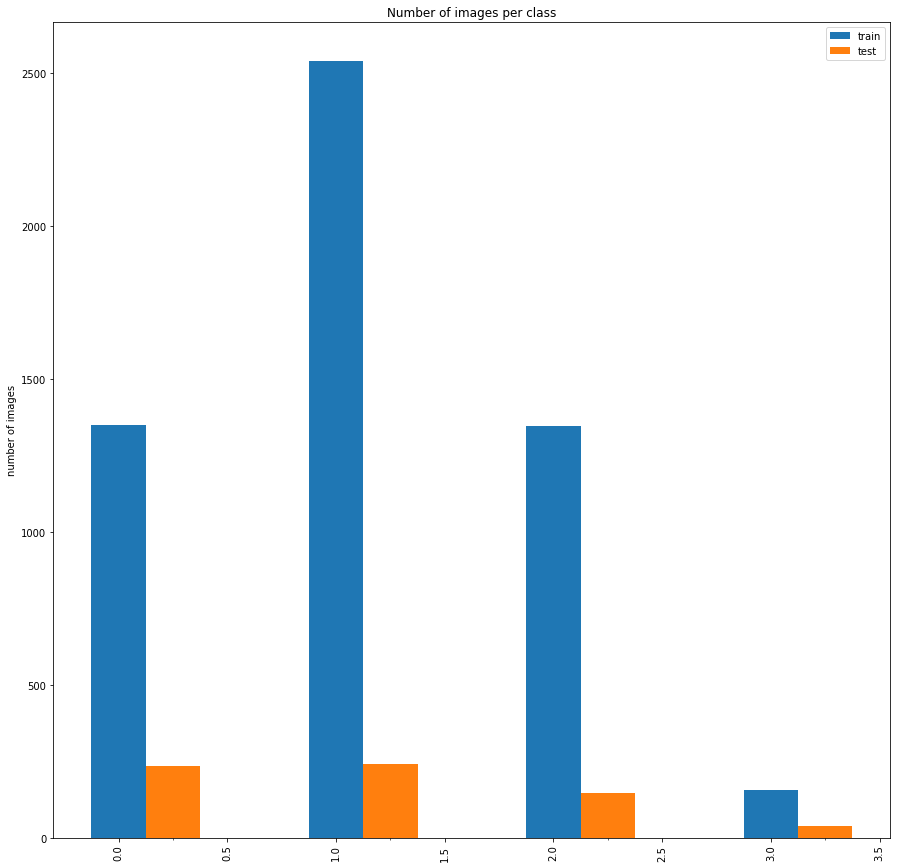

In [163]:
# plot the distribution of the classes on train and test
x = np.arange(4)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for l in ['train', 'test']:
    offset = width * multiplier
    v = [np.sum(y_train == i) if l == 'train' else np.sum(y_test == i) for i in range(4)]
    rects = ax.bar(x + offset, v, width, label=l)
    multiplier += 1

ax.set_ylabel('number of images')
ax.set_title('Number of images per class')
ax.set_xticks(x + width, ['Normal', 'Bacterial', 'Viral', 'COVID-19'])
ax.legend(loc='upper right')

plt.xticks(rotation=90)

plt.show()


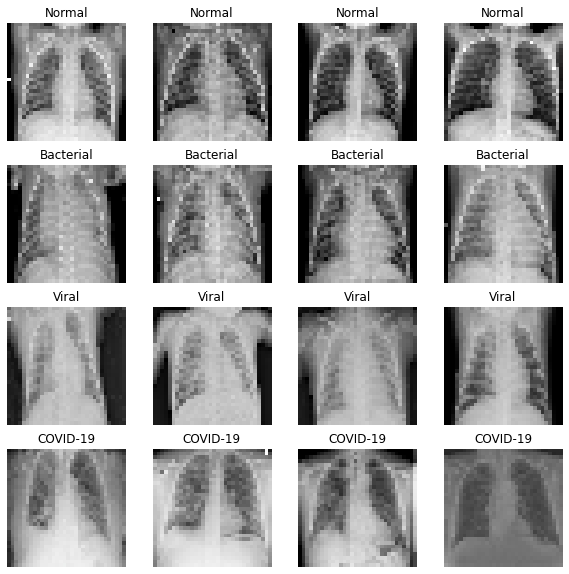

In [164]:
# visualize some images for each class
classes = ['Normal', 'Bacterial', 'Viral', 'COVID-19']
# classes = ['Normal', 'Bacterial', 'Viral', 'COVID-19']

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(X_train[y_train == i][j])
        ax[i, j].set_title(classes[i])
        ax[i, j].axis('off')
plt.show()

In [198]:
# define the utility function for the problem
U = 1*np.eye(4)
U[0,1] = 0.2 # pred = normal, true = bacterial
U[0,2] = 0 # pred = normal, true = bacterial
U[0,3] = 0.1 # pred = normal, true = covid
U[1,0] = 0.1 # pred = bacterial, true = normal
U[1,2] = 0 # pred = bacterial, true = viral
U[1,3] = 0 # pred = bacterial, true = covid
U[2,0] = 0.2 # pred = viral, true = normal
U[2,1] = 0.3 # pred = viral, true = bacterial
U[2,3] = 0.4 # pred = viral, true = covid
U[3,0] = 0.5 # pred = covid, true = normal
U[3,1] = 0.6 # pred = covid, true = bacterial
U[3,2] = 0.7 # pred = covid, true = viral
# U = 2.1 - U
U = 1.0001 - U
print(U)


[[1.e-04 8.e-01 1.e+00 9.e-01]
 [9.e-01 1.e-04 1.e+00 1.e+00]
 [8.e-01 7.e-01 1.e-04 6.e-01]
 [5.e-01 4.e-01 3.e-01 1.e-04]]


In [166]:
num_classes = 4
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training data classes count: {dict(zip(unique,counts))}")
unique, counts = np.unique(y_val, return_counts=True)
print(f"Training data classes count: {dict(zip(unique,counts))}")

Training data classes count: {0.0: 1079, 1.0: 2030, 2.0: 1076, 3.0: 125}
Training data classes count: {0.0: 270, 1.0: 508, 2.0: 269, 3.0: 31}


In [167]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [178]:
x_train = x_train/255
x_val = x_val/255
X_test = X_test/255

In [210]:
help(x_train.flatten)

Help on built-in function flatten:

flatten(...) method of numpy.ndarray instance
    a.flatten(order='C')
    
    Return a copy of the array collapsed into one dimension.
    
    Parameters
    ----------
    order : {'C', 'F', 'A', 'K'}, optional
        'C' means to flatten in row-major (C-style) order.
        'F' means to flatten in column-major (Fortran-
        style) order. 'A' means to flatten in column-major
        order if `a` is Fortran *contiguous* in memory,
        row-major order otherwise. 'K' means to flatten
        `a` in the order the elements occur in memory.
        The default is 'C'.
    
    Returns
    -------
    y : ndarray
        A copy of the input array, flattened to one dimension.
    
    See Also
    --------
    ravel : Return a flattened array.
    flat : A 1-D flat iterator over the array.
    
    Examples
    --------
    >>> a = np.array([[1,2], [3,4]])
    >>> a.flatten()
    array([1, 2, 3, 4])
    >>> a.flatten('F')
    array([1, 3, 2, 4]

In [217]:
x_train = x_train.reshape(-1,IMG_SIZE*IMG_SIZE*3)
x_val = x_val.reshape(-1,IMG_SIZE*IMG_SIZE*3)
X_test = X_test.reshape(-1, IMG_SIZE*IMG_SIZE*3)

In [218]:
Early_Stop_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
# units
units = 80

dropout=0.2
# Regularise
tau = 1.0
lengthscale = .01
reg = lengthscale**2 * (1 - dropout) / (2. * len(x_train) * tau)

def network():
    model = Sequential()
    model.add(Dense(units, activation='relu', input_shape=x_train.shape[1:],W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(num_classes, activation='softmax',W_regularizer=l2(reg)))
    # model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = (32,32,3)))
    # model.add(MaxPooling2D())
    # model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
    # model.add(MaxPooling2D())
    # model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
    # model.add(keras.layers.Flatten())
    # model.add(Dense(128, activation='relu', W_regularizer=l2(reg)))
    # model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    # model.add(Dense(num_classes, activation='softmax',W_regularizer=l2(reg)))
    return model

STD

In [219]:
epochs = 100
batch_size = 16
std_model = network()
std_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

history_std = std_model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=[x_val,y_val],
                  )

c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", input_shape=(3072,), kernel_regularizer=<keras.reg...)`
  del sys.path[0]
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", kernel_regularizer=<keras.reg...)`


Train on 4310 samples, validate on 1078 samples
Epoch 1/100
4310/4310 [==============================] - 2s 535us/step - loss: 1.0205 - acc: 0.5515 - val_loss: 0.8808 - val_acc: 0.6067
Epoch 2/100
4310/4310 [==============================] - 1s 299us/step - loss: 0.8567 - acc: 0.6311 - val_loss: 0.8735 - val_acc: 0.6243
Epoch 3/100
4310/4310 [==============================] - 1s 304us/step - loss: 0.8358 - acc: 0.6413 - val_loss: 0.8061 - val_acc: 0.6419
Epoch 4/100
4310/4310 [==============================] - 1s 297us/step - loss: 0.8451 - acc: 0.6318 - val_loss: 0.8372 - val_acc: 0.6234
Epoch 5/100
4310/4310 [==============================] - 1s 287us/step - loss: 0.8081 - acc: 0.6457 - val_loss: 0.8760 - val_acc: 0.6160
Epoch 6/100
4310/4310 [==============================] - 1s 288us/step - loss: 0.8085 - acc: 0.6492 - val_loss: 0.8301 - val_acc: 0.6373
Epoch 7/100
4310/4310 [==============================] - 1s 300us/step - loss: 0.7862 - acc: 0.6538 - val_loss: 0.8251 - val_acc: 

WEIGHTED

In [220]:
# Set up weight for weighted cross entropy
# goal_class = [3]
class_weight = np.ones((num_classes))
class_weight[0] = 1.4
class_weight[2] = 1.8


In [221]:
we_model = network()
we_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

history_we = we_model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=40,
                  verbose=1,
                  validation_data=[x_val,y_val],
                  class_weight = class_weight, 
                  )


c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", input_shape=(3072,), kernel_regularizer=<keras.reg...)`
  del sys.path[0]
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", kernel_regularizer=<keras.reg...)`


Train on 4310 samples, validate on 1078 samples
Epoch 1/40
4310/4310 [==============================] - 2s 493us/step - loss: 1.0541 - acc: 0.5213 - val_loss: 0.8671 - val_acc: 0.6317
Epoch 2/40
4310/4310 [==============================] - 1s 292us/step - loss: 0.8352 - acc: 0.6253 - val_loss: 0.7843 - val_acc: 0.6438
Epoch 3/40
4310/4310 [==============================] - 1s 307us/step - loss: 0.7878 - acc: 0.6374 - val_loss: 0.7482 - val_acc: 0.6670
Epoch 4/40
4310/4310 [==============================] - 1s 282us/step - loss: 0.7698 - acc: 0.6508 - val_loss: 0.8230 - val_acc: 0.6391
Epoch 5/40
4310/4310 [==============================] - 1s 282us/step - loss: 0.7481 - acc: 0.6691 - val_loss: 0.7829 - val_acc: 0.6614
Epoch 6/40
4310/4310 [==============================] - 1s 293us/step - loss: 0.7350 - acc: 0.6805 - val_loss: 0.7525 - val_acc: 0.6716
Epoch 7/40
4310/4310 [==============================] - 1s 322us/step - loss: 0.7358 - acc: 0.6731 - val_loss: 0.7443 - val_acc: 0.6688


LOSS CALIBRATED

In [222]:
M = 1.0001
basic_model = network()
# Initilise loss
decision_loss = lcbnn.loss_K(U)

H_x = Input(shape=(num_classes,),name='H_x')
y_true = Input(shape=(num_classes,),name='y_true')
x = Input(shape=(x_train.shape[1:]),name='x')

y_pred = basic_model(x)

lc_model = Model([x,H_x],y_pred)
lc_model.compile(loss = lcbnn.cal_loss(decision_loss,M,H_x),optimizer='adam')

#Initiailisations:
y_pred_samples = np.expand_dims(y_train,0)
y_pred_samples_val = np.expand_dims(y_val,0)
H_x = lcbnn.optimal_h(y_pred_samples,U) #np.random.randint(0,2,(np.shape(y_train)))
H_x_val = lcbnn.optimal_h(y_pred_samples_val,U)

history_lc = []
for epoch in range(20):
    h_lc = lc_model.fit([x_train,H_x],[y_train],
                 batch_size=batch_size,
                 nb_epoch=1,
                 verbose=1,
                 validation_data=[[x_val,H_x_val],y_val],
                 )
    T = 10
    yt_hat = np.array([lc_model.predict([x_train,H_x]) for _ in range(T)])
    H_x = lcbnn.optimal_h(yt_hat,U)
    history_lc.append(h_lc)

c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", input_shape=(3072,), kernel_regularizer=<keras.reg...)`
  del sys.path[0]
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", kernel_regularizer=<keras.reg...)`
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:27: UserWa

Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 2s 531us/step - loss: 1.6867 - val_loss: 1.3411
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 300us/step - loss: 1.1515 - val_loss: 1.3110
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 302us/step - loss: 1.0740 - val_loss: 1.1873
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 329us/step - loss: 1.0537 - val_loss: 1.1861
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 292us/step - loss: 1.0457 - val_loss: 1.1855
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 309us/step - loss: 1.0214 - val_loss: 1.2215
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [=========================

RESULTS

In [223]:
T = 100
loss_mat = U
H_x_test = np.zeros_like(y_test)

#######
# STD #
#######
yt_hat_std = np.array([std_model.predict([X_test]) for _ in range(T)])
MC_pred_std = np.mean(yt_hat_std, 0)
H_x_test_std = lcbnn.optimal_h(yt_hat_std,loss_mat) 
acc_std = accuracy_score(np.argmax(y_test,1),np.argmax(H_x_test_std,1))
loss_std = np.mean(lcbnn.loss_np(y_test,H_x_test_std,loss_mat))
print('Standard:\n')
print('Accuracy on optimal decision: ', acc_std)
print('Expected loss: ', loss_std)

#######
# WEI #
#######
yt_hat_we = np.array([we_model.predict([X_test]) for _ in range(T)])
MC_pred_we = np.mean(yt_hat_we, 0)
H_x_test_we = lcbnn.optimal_h(yt_hat_we,loss_mat) 
acc_we = accuracy_score(np.argmax(y_test,1),np.argmax(H_x_test_we,1))
loss_we = np.mean(lcbnn.loss_np(y_test,H_x_test_we,loss_mat))

print('\nWeighted:\n')
print('Accuracy on optimal decision: ', acc_we)
print('Expected loss: ', loss_we)

#######
# L-C #
#######
yt_hat_lc = np.array([lc_model.predict([X_test, H_x_test]) for _ in range(T)])
MC_pred_lc = np.mean(yt_hat_lc, 0)
H_x_test_lc = lcbnn.optimal_h(yt_hat_lc,loss_mat) 
acc_lc = accuracy_score(np.argmax(y_test,1),np.argmax(H_x_test_lc,1))
loss_lc = np.mean(lcbnn.loss_np(y_test,H_x_test_lc,loss_mat))
print('\nLoss-cal:\n')
print('Accuracy on optimal decision: ', acc_lc)
print('Expected loss: ', loss_lc)


Standard:

Accuracy on optimal decision:  0.45331325301204817
Expected loss:  0.2979915662650602

Weighted:

Accuracy on optimal decision:  0.5195783132530121
Expected loss:  0.22916626506024093

Loss-cal:

Accuracy on optimal decision:  0.6310240963855421
Expected loss:  0.22600361445783126


CONFUSION MATRICES

Normalized confusion matrix
[[0.29 0.06 0.   0.65]
 [0.   0.86 0.   0.14]
 [0.02 0.34 0.   0.64]
 [0.33 0.05 0.   0.62]]
Normalized confusion matrix
[[0.27 0.   0.08 0.64]
 [0.   0.77 0.01 0.21]
 [0.02 0.07 0.36 0.54]
 [0.   0.   0.   1.  ]]
Normalized confusion matrix
[[0.39 0.03 0.15 0.43]
 [0.   0.93 0.03 0.04]
 [0.05 0.21 0.45 0.28]
 [0.03 0.07 0.   0.9 ]]


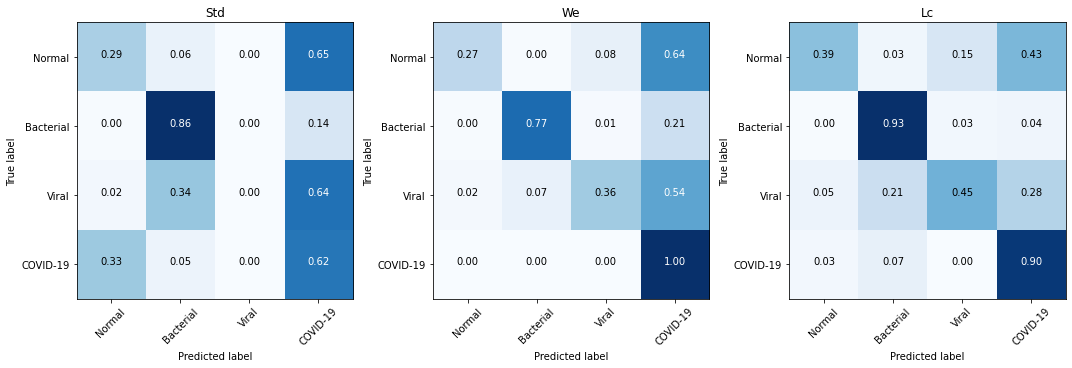

In [225]:
plt.rcParams['figure.figsize'] = (15, 15)

H_std = np.argmax(H_x_test_std, axis=1)
H_we = np.argmax(H_x_test_we, axis=1)
H_lc = np.argmax(H_x_test_lc, axis=1)

Y = np.argmax(y_test, axis=1)
cnf_matrix_std = confusion_matrix(Y.reshape((y_test.shape[0],)).astype('float'),np.round(H_std.reshape((H_x_test.shape[0],))))
np.set_printoptions(precision=2)
cnf_matrix_we = confusion_matrix(Y.reshape((y_test.shape[0],)).astype('float'),np.round(H_we.reshape((H_x_test.shape[0],))))
np.set_printoptions(precision=2)
cnf_matrix_lc = confusion_matrix(Y.reshape((y_test.shape[0],)).astype('float'),np.round(H_lc.reshape((H_x_test.shape[0],))))
np.set_printoptions(precision=2)

plt.subplot(131)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_std, classes=classes, normalize=True,
                      title='Std')

plt.subplot(132)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_we, classes=classes, normalize=True,
                      title='We')

plt.subplot(133)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_lc, classes=classes, normalize=True,
                      title='Lc')
plt.show()

TRAINING STATISTICS

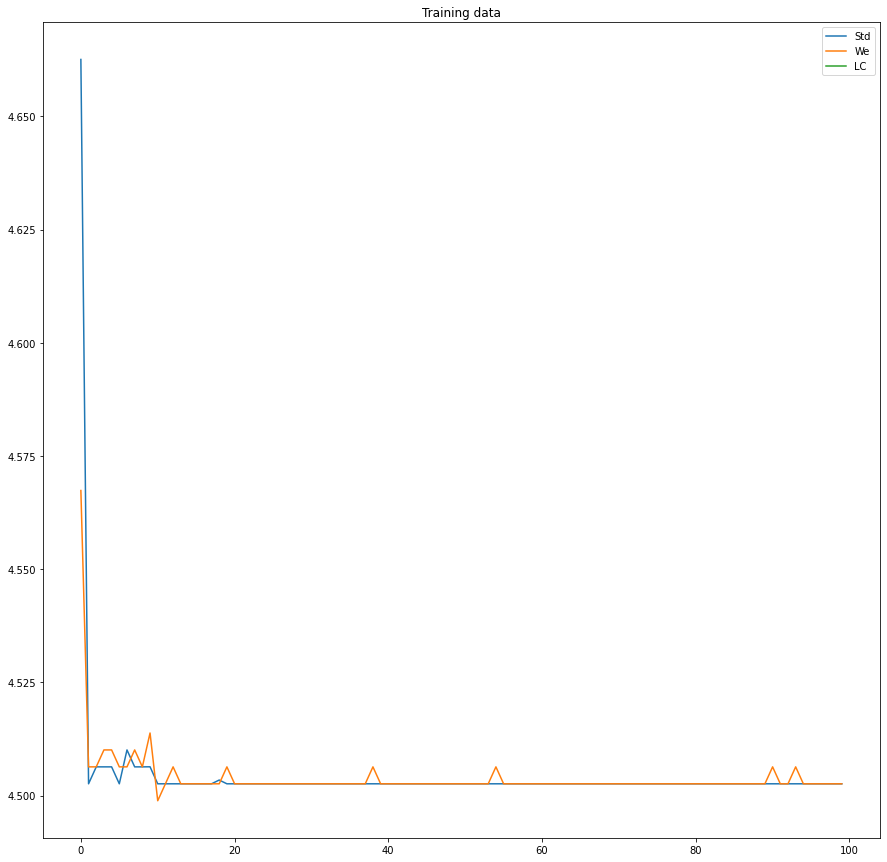

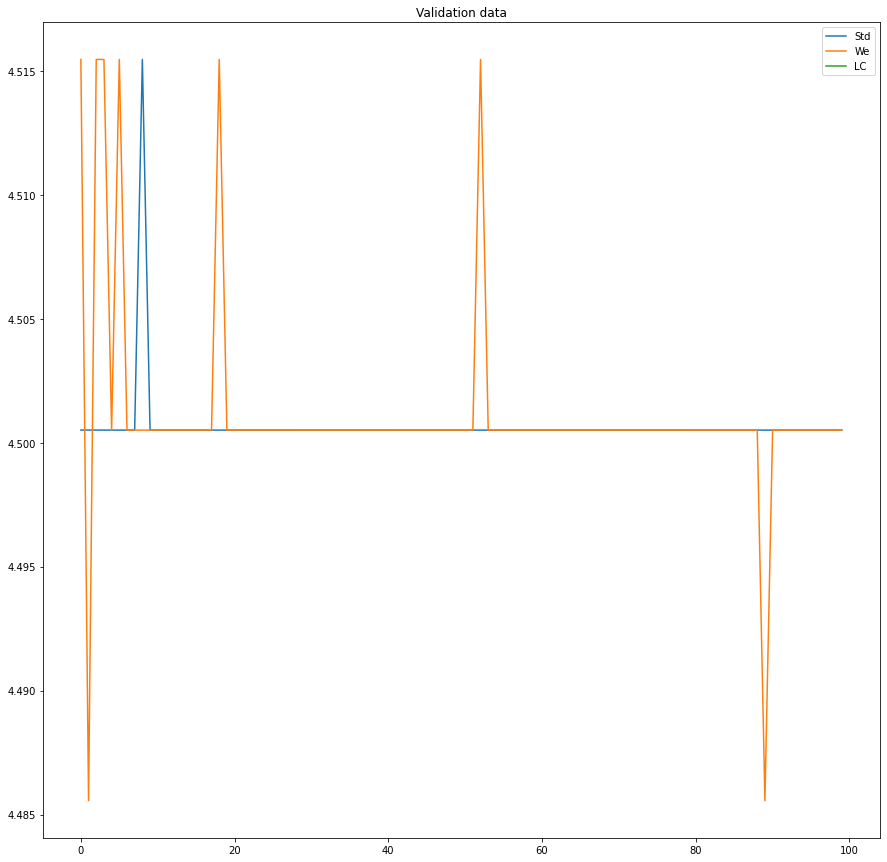

In [71]:
h = []
h_val = []
for i in range(epochs):
    h.append(history_lc[i].history['loss'])
    h_val.append(history_lc[i].history['val_loss'])
    
plt.figure()
plt.title('Training data')
plt.plot(history_std.history['loss'], label='Std')
plt.plot(history_we.history['loss'], label='We')
plt.plot(h,label='LC')
plt.legend()
plt.show()

plt.figure()
plt.title('Validation data')
plt.plot(history_std.history['val_loss'], label='Std')
plt.plot(history_we.history['val_loss'], label='We')
plt.plot(h_val,label='LC')
plt.legend()
plt.show()